## Examples for "solver" module

Solution of the multidimensional Fokker-Planck equation by fast and accurate tensor based methods.

In [1]:
import sys
import time

import numpy as np
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver

---
---

### Solution strategy

We are going to find probability density function (PDF) $\rho(x, t)$ for the spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ which is the solution of the SDE with Brownian motion $\beta$ of dimension $q$ ($q \ge 1$ and we assume below that $q = d$)
$$
    dx = f(x, t) \, dt + S(x, t) \, d\beta,
    \quad
    d\beta \, d\beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
where $f(x, t) \in R^d$ is a vector-function and $S(x, t) \in R^{d \times q}$ is a matrix-function.

It can be shown that the PDF $\rho(x, t)$ at time $t$ ($t > 0$) is the solution of the Fokker-Planck equation
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right]
        + \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
where $D(x, t)$ is a diffusion tensor of the form
$$
    D(x, t) = \frac{1}{2} S(x, t) Q S^{\top}(x, t).
$$

For simplicity we set $Q(t) \equiv 2 I$, $S(x, t) \equiv I$ (hence $D(x, t) \equiv I$) and then come to the following equations
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

Let apply 1st order splitting scheme on the $k$-th time step $kh$ (with known from the previous step $\rho_{k}$)
$$
\frac{\partial v}{\partial t} = \Delta v,
\quad
v_{k} = \rho_{k},
$$
$$
\frac{\partial w}{\partial t} = - div \left[ f(x, t) w \right],
\quad
w_{k} = v_{k+1},
$$
then we can approximate a value of the PDE $\rho$ at time step $k+1$ as $\rho_{k+1} = w_{k+1}$.

Note that equation for $w$ may be refolmulated in terms of the trajectory integration:
$$
    \begin{cases}
        \frac{\partial \, x}{\partial \, t} = f(x, t) \\
        \frac{\partial \, w}{\partial \, t} =
            -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right] w
    \end{cases},
$$
or equivalently
$$
    \begin{cases}
        \frac{\partial \, x}{\partial \, t} = f(x, t) \\
        \frac{\partial \, \log{w}}{\partial \, t} =
            -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right]
    \end{cases}.
$$

---
---

### Algorithm

> This is a draft of the algorithm. which is used in solver module/class (Russian is used for simplicity).

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест (tt-cross) функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу, при этом предполагается, что интерполянт для $k$-ого шага уже известен.

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ODE можем использовать метод Эйлера без потери точности.

**Работа функции step(X)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?,
$$
используя формулу Эйлера
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}).
$$

**2** Используя известный интерполянт $E^{(\rho)}_k$ на $k$-ом шаге, вычислить в точках $\widehat{X}$ значения PDF $\widehat{\rho} = \tilde{E}^{(\rho)}_k(\widehat{X})$, где знак ~ в $\tilde{E}^{(\rho)}_k$ соответствует обнулению значений для точек, которые оказались вне пределов интерполяции.

**3** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = \widehat{\rho},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева 2-ого порядка $D$
$$
    v = 
        \left( e^{\sqrt[d]{h} J D} \otimes \ldots \otimes e^{\sqrt[d]{h} J D} \right)
        \left( J \otimes \ldots \otimes J \right)
        \widehat{\rho},
$$
где матрица $J = diag \left[ 1 \, 1 \, \ldots \, 1 \, 0 \right]$ введена для удовлетворения однородным граничным условиям.

**4** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, w}{\partial \, t} =
        -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right] w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?,
$$
используя формулу Эйлера
$$
    w = \left(
        1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k}) \right]
    \right) v.
$$

**5** Вернуть значение $w$ как приближение $\rho(x)$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

**Примечание** На 4-ом шаге в качестве альтернативного варианта может быть решено эквивалентное уравнение
$$
    \frac{\partial \, \log{w}}{\partial \, t} =
        -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right],
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?.
$$

---
---

### Algorithm (short version)

> This is a draft of the algorithm. which is used in solver module/class (Russian is used for simplicity).

В качестве итоговой формулы (первого порядка точности) для вычисления значения $\rho$ на $(k+1)$-ом временном шаге в заданном (произвольном) наборе точек $X$ Чебышевской сетки по известному интерполянту $E^{(\rho)}_k$ для $\rho$ на $k$-ом шаге получили
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}),
$$
$$
    \rho_{k+1}(X) =
        \left(
            1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k}) \right]
        \right)
        \left( e^{\sqrt[d]{h} J D} \otimes \ldots \otimes e^{\sqrt[d]{h} J D} \right)
        \left( J \otimes \ldots \otimes J \right)
        \tilde{E}^{(\rho)}_k(\widehat{X}),
$$
где знак ~ в $\tilde{E}^{(\rho)}_k$ соответствует обнулению значений для точек, которые оказались вне пределов интерполяции, $D$ - дифференциальная матрица Чебышева 2-ого порядка, а матрица $J = diag \left[ 1 \, 1 \, \ldots \, 1 \, 0 \right]$ введена для удовлетворения однородным граничным условиям.

---
---

### Solution of the 1D diffusion process

Let consider equation
$$
    dx = d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
$$
    x \in \Omega = [-3, 3],
    \quad
    \rho(x, t) |_{\partial \Omega} = 0,
    \quad
    \rho_0(x) = \sin{(\pi x)},
$$
with known exact solution
$$
    \rho(x, t) = \sin{(\pi x)} e^{-\pi^2t}.
$$

In [2]:
def func_f0(x, t):
    return np.zeros(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    r = np.sin(np.pi * x/3)
    return r.reshape(-1)

def func_rt(x, t):
    r = np.sin(np.pi * x/3) * np.exp(-1. * np.pi * np.pi * t)
    return r.reshape(-1)

def func_rs(x):
    r = np.zeros(x.shape)
    return r.reshape(-1)

---

#### Explicit solution

We can solve it on the Chebyshev spatial grid for the time $t > 0$ using uniform time grid with step $h$ and iterations
$$
u_{k+1} = e^{h \cdot J D} J u_{k},
\quad
k = 0, 1, \ldots, \frac{t}{h} - 1,
$$
where $u_{0}(x)$ is the known initial condition, $D$ is the 2th order Chebyshev differentiation matrix and $J = diag \left[ 1 \, 1 \, \ldots \, 1 \, 0 \right]$.

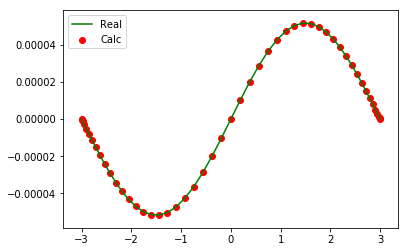

Number of time points    :     1000
Number of spatial points :       51
Error (relative norm)    : 6.01e-10    
Total time (sec)         : 6.55e-02    


In [3]:
_time = time.time()

t_min = 0.
t_max = 1.
t_poi = 1000
x_min = -3.
x_max = +3.
x_poi = 51

IT = Intertrain(n=[x_poi], l=[ [x_min, x_max] ])
X = IT.grid()
T = np.linspace(t_min, t_max, t_poi)
h = (t_max - t_min) / (t_poi - 1)
D = IT.dif2()
J = np.eye(x_poi); J[0, 0] = 0.; J[-1, -1] = 0.
Z = expm(h * J @ D) @ J

r = func_r0(X)
for t in T[1:]:
    r = Z@r

_time = time.time() - _time
    
t = t_max
x = X.reshape(-1)
q = func_rt(X, t)
e = np.linalg.norm(q - r) / np.linalg.norm(q)

plt.plot(x, q, c='g', label='Real')
plt.scatter(x, r, c='r', label='Calc')
plt.legend(loc='best')
plt.show()

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%IT.n[0])
print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)

---

#### Solution by the solver

**Note** Since interpolation is not required for the case $f \equiv 0$, but our solver calculates it by design, then it is expected to operate much slower than explicit simple solver, which was presented above. 

In [4]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(1000, t_min=0., t_max=1.)
SL.set_grid_x(51, x_min=-3., x_max=3.)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|███████| 999/999 [00:10<00:00, 96.42step/s, Norm 2.28e-04]


---------- Solver
Format   : 1D, NP
Grid x   : poi =        51, min =   -3.0000, max =    3.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 5.47e-03, calc = 1.04e+01


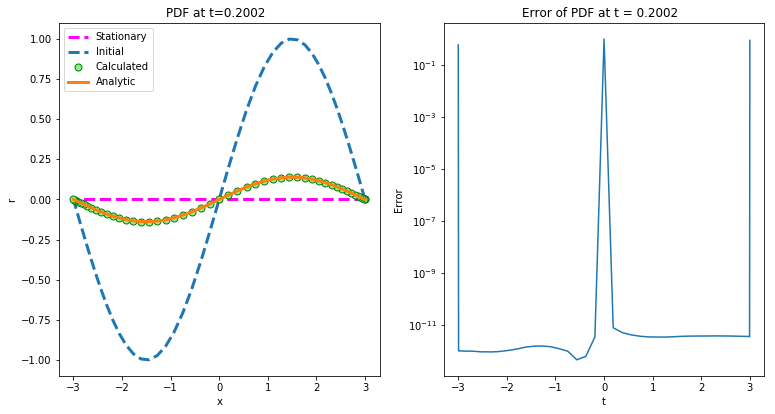

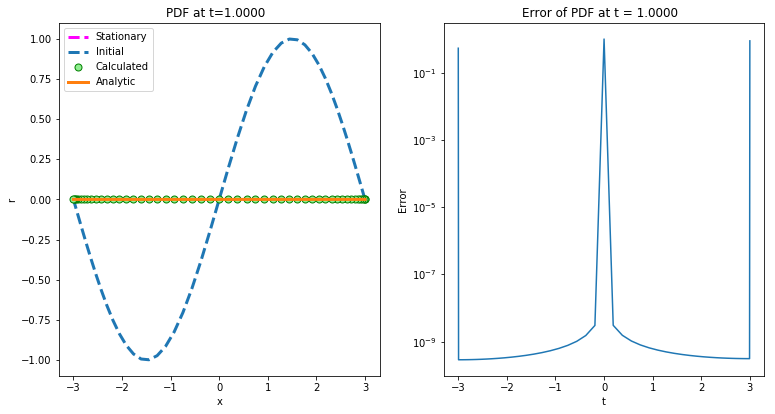

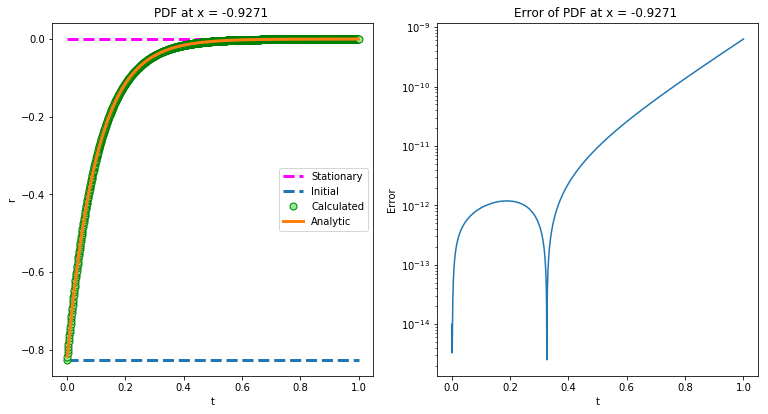

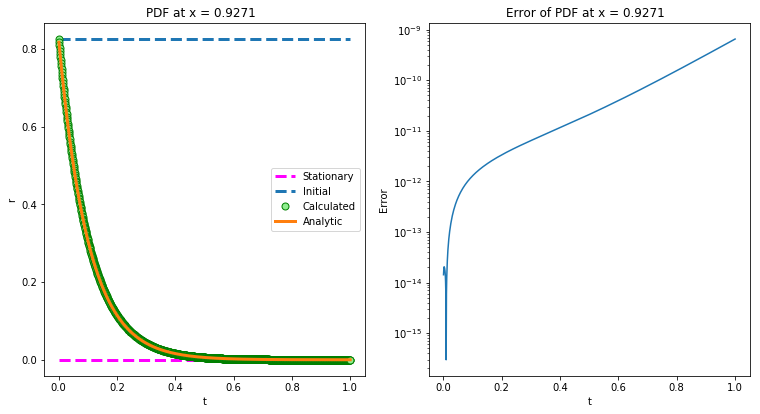

In [7]:
SL.info()
SL.plot_x(t=0.2)
SL.plot_x()
SL.plot_t(x=-1.)
SL.plot_t(x=+1.)

---
---

### Solution of the 1D process with constant drift

Let consider equation
$$
    dx = f(x, t) \, dt + S d\beta,
    \quad
    d \beta \, d \beta^{\top} = Q dt,
    \quad
    \frac{\partial \rho}{\partial t} = - div \left[ f(x, t) \rho \right] + D \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
$$
    x \in \Omega = [-1, 1],
    \quad
    \rho(x, t) |_{\partial \Omega} = 0,
    \quad
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
    \quad
     D = \frac{1}{2} S Q S^{\top},
$$
with 
$$
    f(x, t) = v = const.
$$

This equation has exact solution ([see this paper](http://www.icmp.lviv.ua/journal/zbirnyk.73/13002/art13002.pdf))
$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 D t}}
        \exp{\left[
            - \frac
                {
                    \left( x - x_0 - v t \right)^2
                }
                {
                    4 D t
                }
        \right]},
$$
where $x_0$ is an initial condition. We can rewrite this equation in terms of initial PDF $\rho_0(x)$ as
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0,
$$
which leads to 
$$
    \rho(x, t) = ...
$$

In [8]:
A = 2.

def func_f0(x, t):
    return A * x

def func_f1(x, t):
    return A * np.ones(x.shape)

def func_r0(x):
    r = x + x
    return r.reshape(-1)

def func_rt(x, t):
    r = x + x
    return r.reshape(-1)

def func_rs(x):
    r = x + x
    return r.reshape(-1)

---

#### Explicit solution

We can solve it using our algorithm from above.

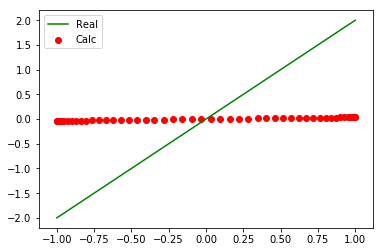

Number of time points    :     1000
Number of spatial points :       50
Error (relative norm)    : 9.82e-01    
Total time (sec)         : 1.60e+00    


In [9]:
_time = time.time()

t_min = 0.
t_max = 1.
t_poi = 1000
x_min = -1.
x_max = +1.
x_poi = 50

IT = Intertrain(n=[x_poi], l=[[x_min, x_max]], with_tt=False)

X = IT.grid()
T = np.linspace(t_min, t_max, t_poi)
h = (t_max - t_min) / (t_poi - 1)

def step(X):
    f0 = func_f0(X, IT.t)
    X0 = X - h * f0
    f1 = func_f1(X0, IT.t - h)
    r0 = IT0.calc(X0)

    r = (1. - h * np.trace(f1)) * r0

    return r

r = func_r0(X)

IT.init(func_r0).prep()
IT0 = IT.copy()

for i, t in enumerate(T[1:]):
    IT.t = t
    IT0 = IT.copy()
    IT.init(step).prep()

r = IT.calc(X)

_time = time.time() - _time
    
t = t_max
x = X.reshape(-1)
q = func_rt(X, t)
e = np.linalg.norm(q - r) / np.linalg.norm(q)

plt.plot(x, q, c='g', label='Real')
plt.scatter(x, r, c='r', label='Calc')
plt.legend(loc='best')
plt.show()

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%IT.n[0])
print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)

---

#### Solution by the solver

**Note** Since interpolation is not required for the case $f \equiv 0$, but our solver calculates it, then it is expected to operate much slower than explicit simple solver, which was presented above. 

In [12]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(1000, t_max=1.)
SL.set_grid_x(51, x_min=-1., x_max=1.)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs, s0=None)
SL.prep()
SL.calc()

Solve: 100%|██████| 999/999 [00:09<00:00, 106.74step/s, Norm 1.86e-01]


---------- Solver
Format   : 1D, NP
Grid x   : poi =        51, min =   -1.0000, max =    1.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 2.36e-03, calc = 9.36e+00


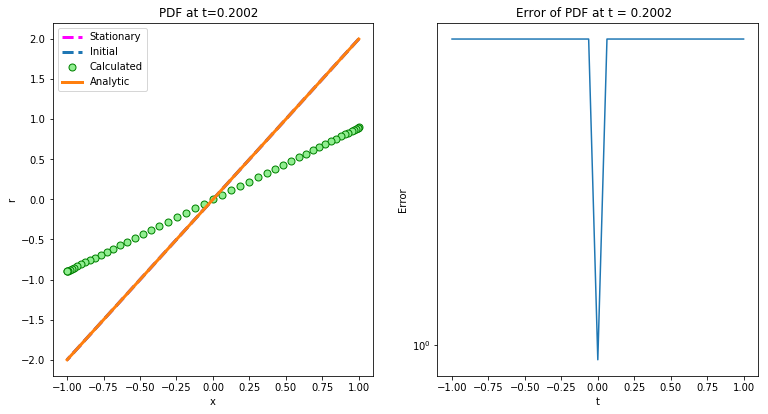

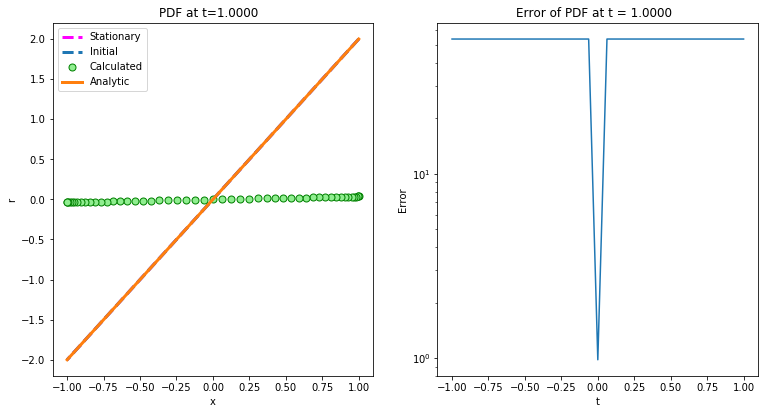

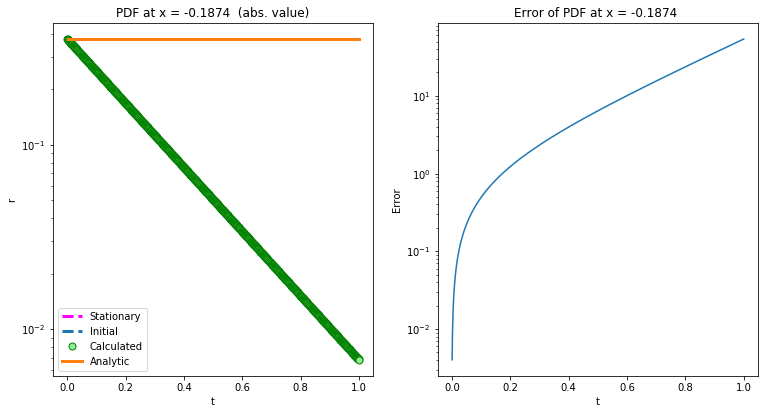

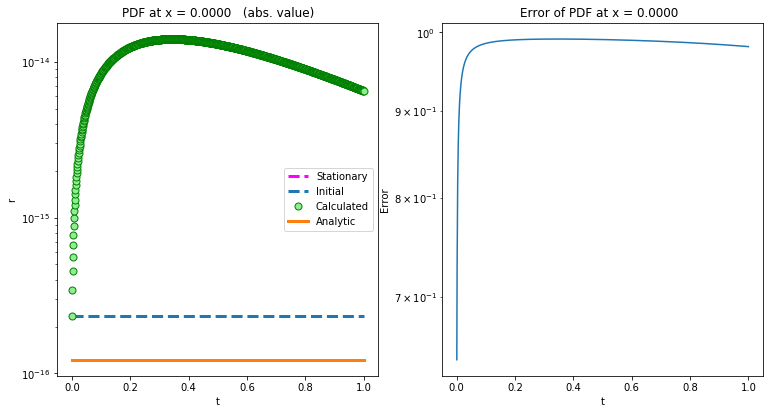

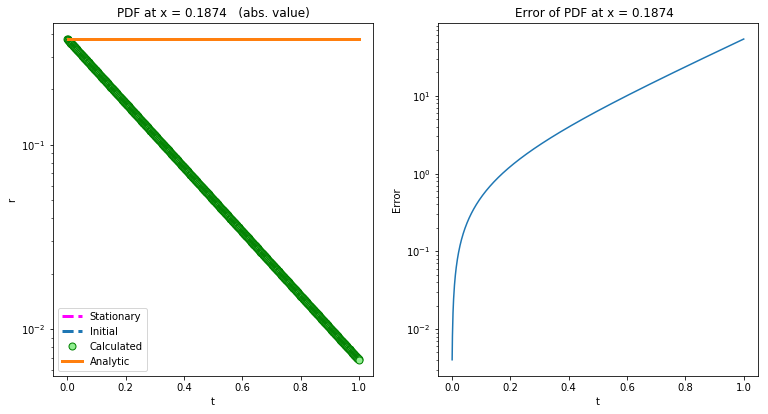

In [13]:
SL.info()
SL.plot_x(t=0.2)
SL.plot_x()
SL.plot_t(x=-0.2, is_log=True, is_abs=True)
SL.plot_t(x=0., is_log=True, is_abs=True)
SL.plot_t(x=0.2, is_log=True, is_abs=True)

---
---

### Solution of the Ornstein–Uhlenbeck process

Let
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$
then we come to the multivariate Ornstein–Uhlenbeck process
$$
    d \, x(t) = A \left( \mu - x(t) \right) d \, t + S d \, \beta(t),
$$
where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $A \in R^{d \times d}$ is the velocity (invertible real matrix);

- $S \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown (see [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)) that

- Mean vector
$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu
$;

- Covariance matrix
$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} d \, s
$;

- Transitional PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $A$ are positive (if $A > 0$ in the one dimensional case).

---

#### Solution of the 1D Ornstein–Uhlenbeck process

Let solve
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
with
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$
where $A > 0$ is the velocity, $\mu$ is the long-term mean, $S > 0$ is the friction coefficient.

Let $\mu \equiv 0$ and $S \equiv 1$, then we have

- Mean value
$
    M(t, x_0) = e^{-A t} x_0
$;

- Covariance matrix
$
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A} 
$;

- Transition PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        exp \left[
            -\frac{(x - M(t, x_0))^2}{2 \Sigma(t)}
        \right] =  
            \sqrt{
                \frac{A}{\pi \left( 1 - e^{-2 A t} \right)}
            }
            e^{\frac
                {-A \left( x - x_0 e^{-A t} \right)^2}
                {1 - e^{-2 A t}}
            }
$.

- Stationary PDF ($t \rightarrow \infty$)
$
    \rho_{\infty}(x) =  
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2}
$.

- PDF
$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}
$  for initial condition
$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]}
$
(see proof below).

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
        \right]},
$$
and fixed initial condition
$$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
$$
from equation
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
            \right]}
            \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
                + \frac{x e^{-A t}}{\Sigma(t)} x_0
            \right]}
            \, d x_0,
$$

Since
$$
    \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
        \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
    \quad
    a > 0,
$$
we come to
$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
        \exp{\left[
            \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s x^2 e^{-2 A t}
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            -
            \frac
                {
                    x^2
                }
                {
                    2 \Sigma(t)
                }
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            x^2
        \right]},
$$

$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}.
$$

In [1]:
import sys
import time

import numpy as np
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver

In [11]:
A = 10.
m = 0. # Should be always zero!
s = 0.001

def func_f0(x, t):
    return A * (-1. * x + m)

def func_f1(x, t):
    return -1. * A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-1. * A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

In [12]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(4000, t_min=0., t_max=4.)
SL.set_grid_x(51, x_min=-1., x_max=1.)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|█████| 3999/3999 [00:42<00:00, 93.85step/s, Norm 2.12e+00]


---------- Solver
Format   : 1D, NP
Grid x   : poi =        51, min =   -1.0000, max =    1.0000
Grid t   : poi =      4000, min =    0.0000, max =    4.0000
Time sec : prep = 3.78e-03, calc = 4.26e+01


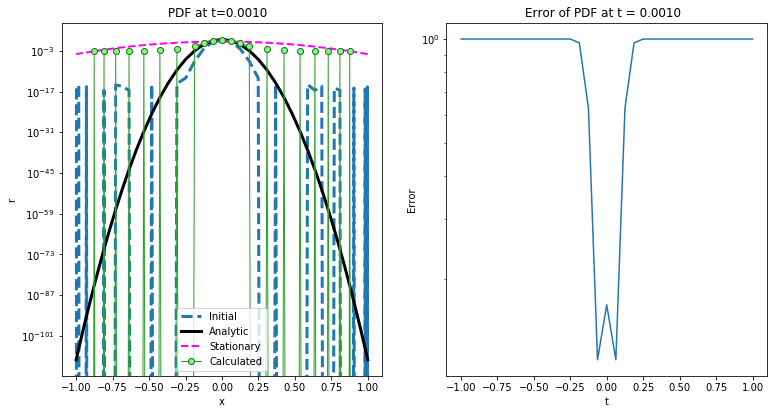

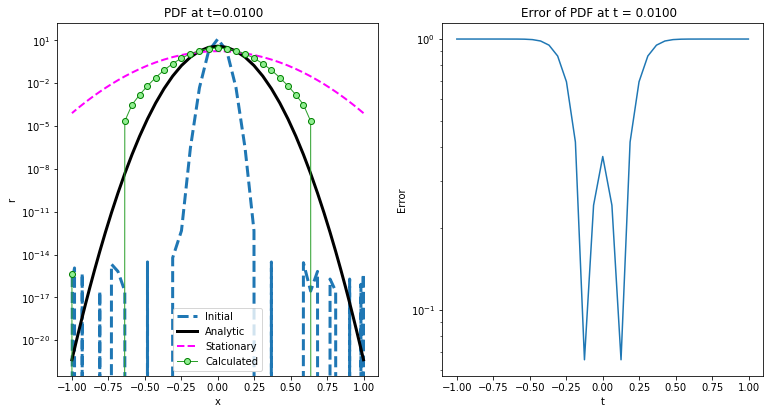

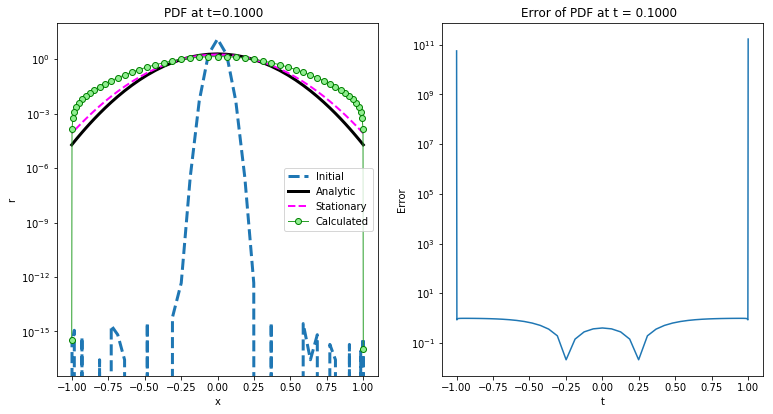

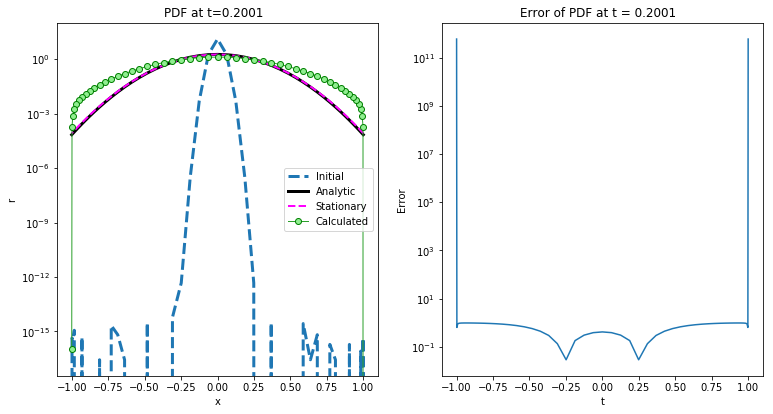

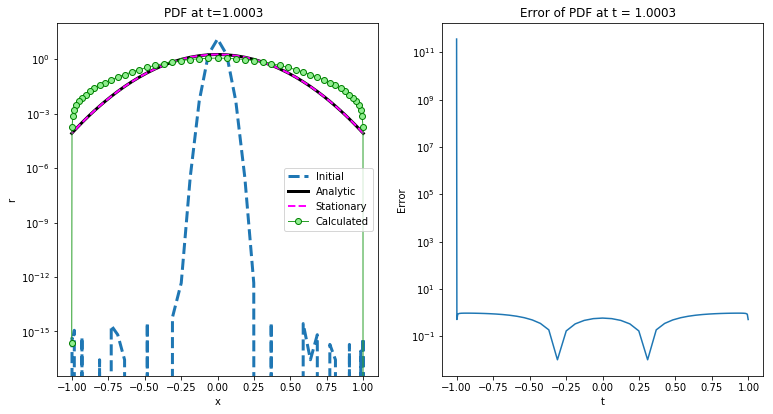

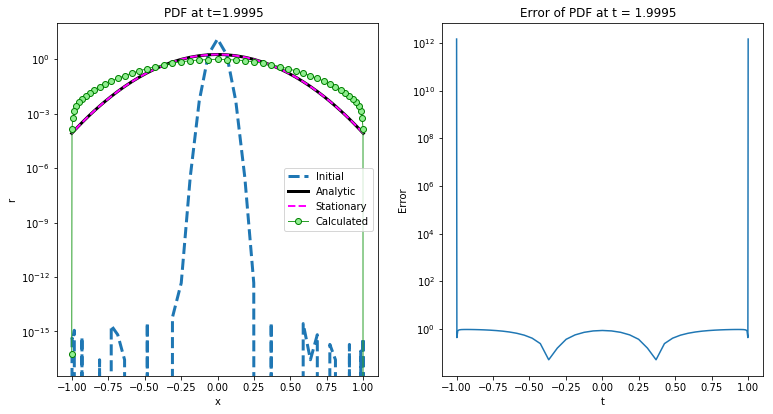

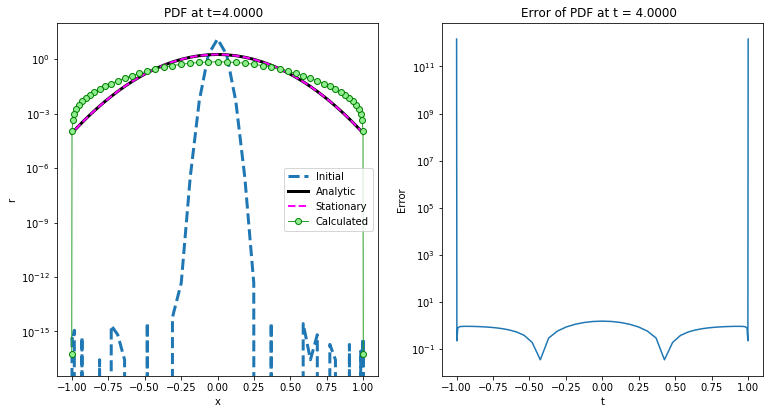

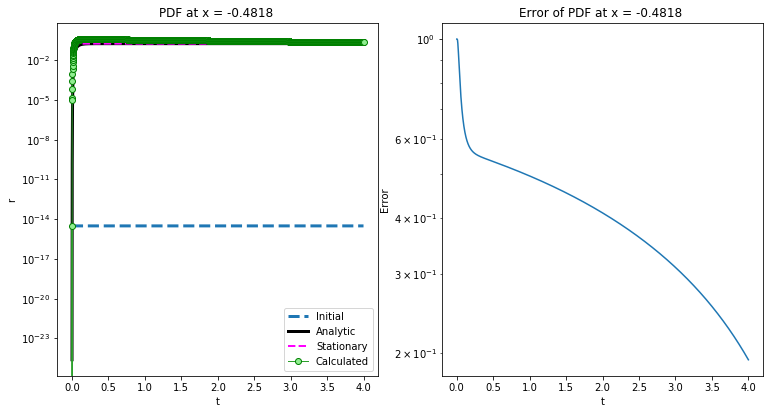

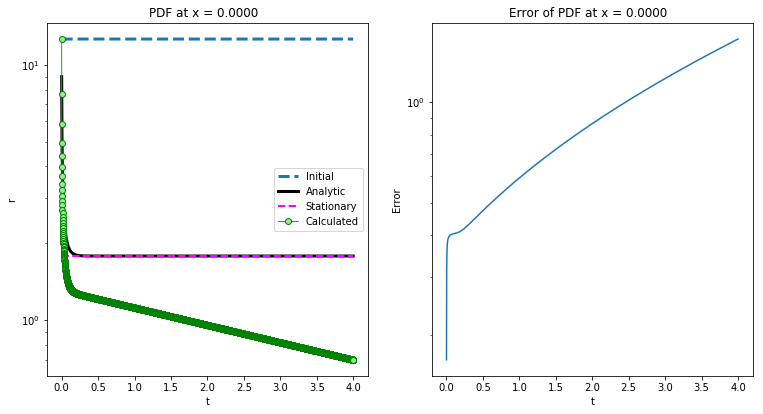

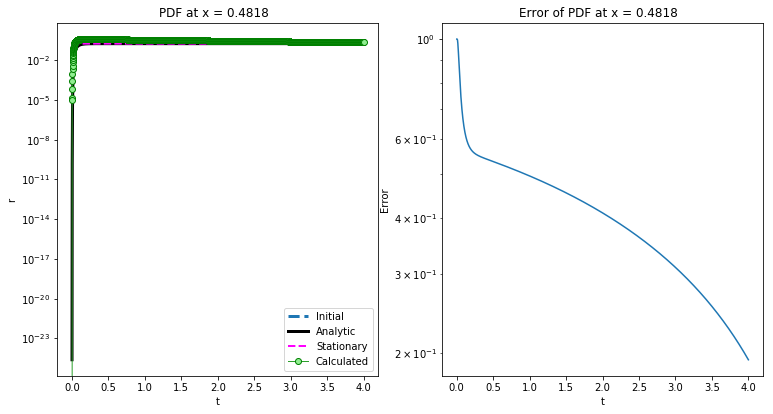

In [13]:
SL.info()
SL.plot_x(t=+0.001, is_log=True)
SL.plot_x(t=+0.01, is_log=True)
SL.plot_x(t=+0.1, is_log=True)
SL.plot_x(t=+0.2, is_log=True)
SL.plot_x(t=+1.0, is_log=True)
SL.plot_x(t=+2.0, is_log=True)
SL.plot_x(t=+4.0, is_log=True)
SL.plot_t(x=-0.5, is_log=True)
SL.plot_t(x=+0.0, is_log=True)
SL.plot_t(x=+0.5, is_log=True)

---

#### Solution of the 2D Ornstein–Uhlenbeck process

Let solve
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
with
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$

where $A \in R^{d \times d}$ is the velocity (invertible real matrix), $\mu \in R^{d}$ is the long-term mean, $S \in R^{d \times q}$ are the friction coefficients (positive real matrix) and $d=q=2$.

---
---

In [ ]:
# SL.anim(ffmpeg_path='./../tmp/ffmpeg', delt=200)